# Building a gene network from the IDR and STRINGdb

This notebook examplifies how to build figure 1b of the paper using the IDR api. 

## Preamble

In [1]:
import requests
from pandas import DataFrame,read_csv, concat
from io import StringIO
import omero

from py2cytoscape.data.cyrest_client import CyRestClient
import py2cytoscape.util.dataframe as cydf
import numpy as np
from IPython.display import Image
import py2cytoscape.cytoscapejs as renderer

<IPython.core.display.Javascript object>

In [2]:
from idr_demo import connection

conn = connection()

In [3]:
def getBulkAnnotationAsDf(screenID,conn):
#    ofId=8118685
    sc=conn.getObject('Screen',screenID)
    for ann in sc.listAnnotations():
        if isinstance(ann, omero.gateway.FileAnnotationWrapper):
            if (ann.getFile().getName()=='bulk_annotations'):
                if (ann.getFile().getSize()> 147625090): #about 140Mb?
                    print "that's a big file..."
                    return None
                ofId=ann.getFile().getId()
                break


    original_file = omero.model.OriginalFileI(ofId, False)

    openTable = conn.c.sf.sharedResources().openTable(original_file)
    rowCount = openTable.getNumberOfRows()

    #table to df

    column_names = [col.name for col in openTable.getHeaders()]

    black_list = []
    column_indices = []
    for column_name in column_names:
        if column_name in black_list:
            continue
        column_indices.append(column_names.index(column_name))

    table_data = openTable.slice(column_indices, None)
    data = []
    for index in range(rowCount):
        row_values = [column.values[index] for column in table_data.columns]
        data.append(row_values)

    dfAnn=DataFrame(data)
    dfAnn.columns=column_names
    return dfAnn


In [4]:
def getGenesFromPhenotype(df,phTerm):
    colElong=[]
    for col in df.columns:
        if ('Term Accession' in col):
            if (phTerm in df[col].unique()):
                colElong.append(col)

    dfElong=concat([df[df[col]!= ''] for col in colElong])
    return dfElong['Gene Identifier'].unique()
    

## Querying the IDR

We will downloiad the annotation for the three screens under study as panda DataFrames, and sub-select the genes from each which are annotated with the phenotype we are looking for, CMPO_0000077 a.k.a. 'elongated cell phenotype'.

The next step is to build, from that list, a list of ids we can query the STRING database with. The translation table was built offline using biomart and pombase. 

In [5]:
#CMPO term to look for
phTerm='CMPO_0000077'

#ids of screens:
#scId=3 #Graml et al.
#scId=206 #Rohn et al., B
#scId=1202 #Fuchs et al., B

screens=[3,206,1202]

genes=[]
for scId in screens:
    print 'loading '+str(scId)

    #loading bulk_annotations of screens as dataframes
    df=getBulkAnnotationAsDf(scId,conn)
    
    #unique genes with CPMO term
    cur=getGenesFromPhenotype(df,phTerm)
    print 'got '+str(len(cur))+ ' genes'
    genes.extend(cur)

loading 3
got 39 genes
loading 206
got 72 genes
loading 1202
got 89 genes


In [6]:
#translation; the table was build off line using biomart
dfTrans=read_csv('TableOfGenesWithElongatedCellPhenotype.csv')

#extract IDs 
genesE84=concat([dfTrans[dfTrans['Screen GeneID']==x]['Human Ortholog Ensembl 84'] for x in genes])
genesE84=genesE84[genesE84!='(null)']

print genes[:10]
print genesE84.head(10)

['SPAC3G9.08', 'SPCC970.10c', 'SPCC553.08c', 'SPAC16C9.05', 'SPAC30.02c', 'SPAC3H8.05c', 'SPCC306.04c', 'SPCC338.16', 'SPCP1E11.06', 'SPAC1556.01c']
15    ENSG00000071243
16    ENSG00000111653
17    ENSG00000168395
18    ENSG00000168556
47    ENSG00000103549
48    ENSG00000155827
44    ENSG00000140598
2     ENSG00000109118
11    ENSG00000198841
40    ENSG00000099381
Name: Human Ortholog Ensembl 84, dtype: object


## REST query of STRING db

We use the STRINGdb rest api to get all the known interactor of all of our genes


In [7]:
#building STRINdb REST api query
url='http://string-db.org/api/psi-mi-tab/interactionsList?identifiers='
for g in genesE84:
    url=url+g+'%250D'
Res = requests.get(url)

In [8]:
df=read_csv(StringIO(Res.text),sep='\t',header=None)
df.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,string:9598.ENSPTRP00000029462,string:9598.ENSPTRP00000007198,RAD50,MRE11A,-,-,-,-,-,taxid:9598,taxid:9598,-,-,-,score:0.999|nscore:0.438|ascore:0.148|escore:0...
1,string:9606.ENSP00000390475,string:9606.ENSP00000264515,CXXC1,RBBP5,-,-,-,-,-,taxid:9606,taxid:9606,-,-,-,score:0.999|escore:0.999|dscore:0.9|tscore:0.883
2,string:9598.ENSPTRP00000057559,string:9598.ENSPTRP00000044421,RBBP5,ASH2L,-,-,-,-,-,taxid:9598,taxid:9598,-,-,-,score:0.999|escore:0.958|dscore:0.443|tscore:0...
3,string:9606.ENSP00000362948,string:9606.ENSP00000297347,MED18,MED30,-,-,-,-,-,taxid:9606,taxid:9606,-,-,-,score:0.999|escore:0.999|dscore:0.9|tscore:0.304
4,string:9606.ENSP00000369810,string:9606.ENSP00000220509,VPS16,VPS18,-,-,-,-,-,taxid:9606,taxid:9606,-,-,-,score:0.999|ascore:0.115|escore:0.999|dscore:0...
5,string:9606.ENSP00000355731,string:9606.ENSP00000314458,CDC42BPA,CDC42,-,-,-,-,-,taxid:9606,taxid:9606,-,-,-,score:0.999|escore:0.845|dscore:0.9|tscore:0.977
6,string:9606.ENSP00000340896,string:9606.ENSP00000264515,ASH2L,RBBP5,-,-,-,-,-,taxid:9606,taxid:9606,-,-,-,score:0.999|ascore:0.065|escore:0.999|dscore:0...
7,string:9606.ENSP00000390475,string:9606.ENSP00000267197,CXXC1,SETD1B,-,-,-,-,-,taxid:9606,taxid:9606,-,-,-,score:0.999|ascore:0.14|escore:0.994|dscore:0....
8,string:9598.ENSPTRP00000025759,string:9598.ENSPTRP00000016637,RHOA,ARHGDIA,-,-,-,-,-,taxid:9598,taxid:9598,-,-,-,score:0.999|ascore:0.084|escore:0.958|dscore:0...
9,string:9598.ENSPTRP00000005889,string:9598.ENSPTRP00000005773,PARVA,ILK,-,-,-,-,-,taxid:9598,taxid:9598,-,-,-,score:0.999|escore:0.958|dscore:0.91|tscore:0.887


## Building Cytoscape network

Cytoscape is then used to display the network. This can be done in one of two ways, either by connecting to a running cytoscape desktop application or directly in browser using cytoscape.js

In [9]:
from IPython.display import display

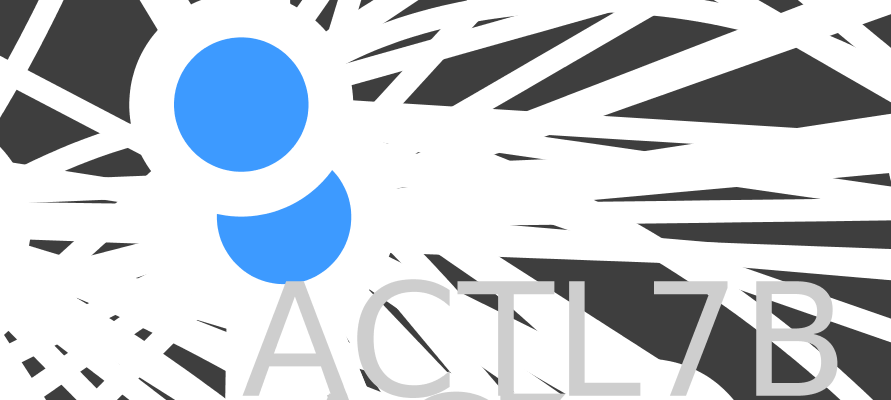

In [10]:

### Using the cytoscape REST api, needs a cytoscape desktop app running 

# Create Client
cy = CyRestClient(ip="192.168.1.99")
# Clear current session
cy.session.delete()

#create network (will appear in the cytoscape desktop windows)
net1 = cy.network.create_from_dataframe(df, source_col=2,target_col=3,interaction_col=10)

cy.layout.apply(network=net1)
cy.layout.fit(network=net1)

style_s3 = cy.style.create('Sample3')
cy.style.apply(style=style_s3, network=net1)

#get display as static render of cytoscape
display(Image(net1.get_png(height=400)))


In [12]:
renderer.render(cydf.from_dataframe(df, source_col=2,target_col=3,interaction_col=10),layout_algorithm='circle',style='Big Labels')